In [1]:
import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random
from jax.scipy.special import logsumexp

import jax

from optax import apply_updates, sgd
from tqdm import tqdm

import numpy as np
import torch
from torch.utils import data
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt

In [2]:
def random_layer_params(m, n, key):
    """
    b: visible bias
    c: hidden bias
    
    """
    w = random.normal(key, (m, n)) * 0.01
    b = jnp.zeros((m,))
    c = jnp.zeros((n,))
    return w, b, c

In [3]:
def init_network_params(layer_sizes, key):
    W, b, c = random_layer_params(layer_sizes[0], layer_sizes[1], key)
    return [W, b, c]

In [4]:
@jit
def sigmoid(x):
    return 1/(1+jnp.exp(-x))

def relu(x):
    return jnp.maximum(x, 0)

@jit
def linear(x, W, b):
    return jnp.dot(x, W.T) + b

In [5]:
@jit
def hidden_sampling(params, v):
    W, b, c = params
    activations = linear(v, W.T, c)
    probs = sigmoid(activations)
    states = random.bernoulli(key, probs)
    return probs, states

@jit
def visible_sampling(params, h):
    W, b, c = params
    activations = linear(h, W, b)
    probs = sigmoid(activations)
    states = probs
    return probs, states

@jit
def gibbs_sampling(params, v):
    v = jnp.array(v).reshape(28 * 28)
    v_tilde = v
    for i in range(steps):
        _, h_tilde = hidden_sampling(params, v_tilde)
        _, v_tilde = visible_sampling(params, h_tilde)

    return h_tilde, v_tilde


batched_hidden_sampling = vmap(hidden_sampling, in_axes=(None, 0))
batched_visible_sampling = vmap(visible_sampling, in_axes=(None, 0))
batched_sampling = vmap(gibbs_sampling, in_axes = (None, 0))

In [6]:
@jit
def energy(params, v):
    W, b, c = params
    activations = linear(v, W.T, c)
    h = jnp.sum(jax.nn.softplus(activations))
    v = jnp.dot(v, b.T)
    return -v-h

batched_energy = vmap(energy, in_axes = (None, 0))

In [7]:
def cost(params, v, v_tilde):
    cost = jnp.mean(batched_energy(params, v)) - jnp.mean(batched_energy(params, v_tilde))
    return cost

# Uses just JAX's grad
@jit  # Yay, it worked
def update(params, v, v_tilde, opt_state):
    dW, dB, dC = grad(cost)(params, v, v_tilde)
    W, b, c = params
    W -= step_size * dW
    b -= step_size * dB
    c -= step_size * dC
    return [W, b, c]


# Uses Optax
# @jit
# def update(params, v, v_tilde, opt_state):
#     grads = grad(cost)(params, v, v_tilde)
#     updates, opt_state = optimizer.update(grads, opt_state)
#     return apply_updates(params, updates)

In [8]:
key = random.PRNGKey(1)
step_size = 0.05
num_epochs = 10
batch_size = 128
n_targets = 10
steps = 2

In [9]:
train = datasets.MNIST(
    root='./data', train=True, download=True, transform=transforms.ToTensor())

test = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size, shuffle=True)

In [10]:
# Params
params = init_network_params([784, 128], key)
len(params)

3

In [11]:
optimizer = sgd(learning_rate=step_size)
opt_state = optimizer.init(params)

In [12]:
for epoch in range(num_epochs):
    start = time.time()
    MSE = 0
    for x, y in tqdm(train_loader):
        
        v = jnp.array(x).reshape(x.size(0), 28 * 28)
        h_tilde, v_tilde = batched_sampling(params, v)
        
        params = update(params, v, v_tilde, opt_state)
        
        # MSE
        batch_size = x.size(0)
        batch_mse = jnp.divide(jnp.sum(jnp.power(v - v_tilde, 2)), batch_size)
        
        MSE += batch_mse
        
    epoch_time = time.time() - start
    print(f'Epoch {epoch} in {epoch_time:0.2f} sec with MSE: {MSE/len(train_loader)}')

100%|█████████████████████████████████████████| 469/469 [00:08<00:00, 55.53it/s]


Epoch 0 in 8.45 sec with MSE: 39.99150466918945


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.56it/s]


Epoch 1 in 6.84 sec with MSE: 24.121065139770508


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.95it/s]


Epoch 2 in 6.71 sec with MSE: 20.2661075592041


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.81it/s]


Epoch 3 in 6.72 sec with MSE: 18.205175399780273


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.98it/s]


Epoch 4 in 6.80 sec with MSE: 16.99628448486328


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.22it/s]


Epoch 5 in 6.78 sec with MSE: 16.171939849853516


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.92it/s]


Epoch 6 in 6.71 sec with MSE: 15.557933807373047


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.09it/s]


Epoch 7 in 6.79 sec with MSE: 15.094781875610352


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.09it/s]


Epoch 8 in 6.79 sec with MSE: 14.72701644897461


100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.84it/s]

Epoch 9 in 6.81 sec with MSE: 14.43231201171875


In [13]:
@jit
def reconstruct(images, params):
    h_t, v_t = batched_sampling(params, images)
    return v_t

In [17]:
def plot_images(images, params, num_images=5):
    v_t = reconstruct(images, params)
    fig = plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = fig.add_subplot(num_images, 2, 2*i+1)
        ax.title.set_text('Original Image')
        plt.imshow(images[i].reshape(28, 28))
        
        ax2 = fig.add_subplot(num_images, 2, 2*i+2)
        ax2.title.set_text('Reconstructed Image')

        plt.imshow(v_t[i].reshape(28, 28))
    fig.tight_layout(pad=10)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

In [18]:
images = jnp.array(x).reshape(x.size(0), 28 * 28)

/tmp/ipykernel_14190/4167447502.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(pad=10)


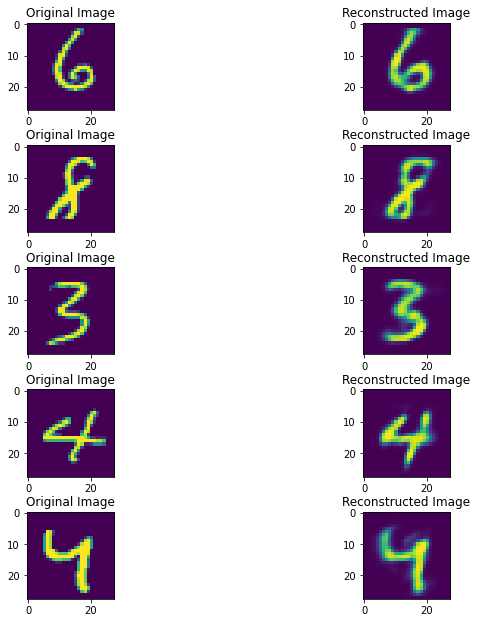

In [19]:
plot_images(images, params)